## 0. Dependency Installation ##

In [2]:
!pip3 install matplotlib seaborn pandas pyarrow
!pip3 install requests

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import requests, io
import re

## 1. Data Loading ##

In [69]:
# GitHub raw file link
data_url = "https://github.com/ChemBioHTP/EnzyExtract/raw/main/data/export/TheData_kcat.parquet"

# Fetch the file into memory without saving to disk
resp = requests.get(data_url)
resp.raise_for_status()  # raise error if download fails

# Read parquet from bytes using pyarrow
table = pq.read_table(io.BytesIO(resp.content))
enzy_data = table.to_pandas()

# Display basic information about the dataset
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [70]:
# Display basic information about the dataset
print("Number of rows:", len(enzy_data))
print("Number of columns:", len(enzy_data.columns))

print("Column names:")
print(enzy_data.columns)

print("First 5 rows of the dataset:")
print(enzy_data.head(10))

print("Dataset info:")
print(enzy_data.info())

Number of rows: 242115
Number of columns: 35
Column names:
Index(['enzyme', 'enzyme_full', 'substrate', 'substrate_full', 'mutant',
       'organism', 'kcat', 'km', 'kcat_km', 'temperature', 'pH', 'solution',
       'cofactors', 'other', 'descriptor', 'pmid', 'canonical', 'clean_mutant',
       'cid', 'brenda_id', 'smiles', 'cid_full', 'brenda_id_full',
       'enzyme_ecs', 'enzyme_ecs_full', 'kcat_value', 'km_value', 'sequence',
       'sequence_source', 'uniprot', 'ncbi', 'pdb', 'max_enzyme_similarity',
       'max_organism_similarity', 'total_similarity'],
      dtype='object')
First 5 rows of the dataset:
              enzyme                                        enzyme_full  \
0            GPI-PLC  glycosylphosphatidylinositol-specific phosphol...   
1            GPI-PLC  glycosylphosphatidylinositol-specific phosphol...   
2            GPI-PLC  glycosylphosphatidylinositol-specific phosphol...   
3            GPI-PLC  glycosylphosphatidylinositol-specific phosphol...   
4       

## 2. EDA ##
### 2.1 Cleaning ###

Explore the dataset to drop columns with missing rate above a reasonable threshold.

Sorted missing ratio per column (top 10 with most missing values):
solution            1.000000
other               1.000000
ncbi                0.986535
cofactors           0.956958
enzyme_ecs_full     0.790649
pdb                 0.765368
brenda_id_full      0.745708
cid_full            0.735142
total_similarity    0.715825
substrate_full      0.601900
dtype: float64


Total columns with 1+ missing values: 35
Max missing ratio: 1.0
Min missing ratio: 0.0


Columns with missing ratio >0%: 31
Columns with missing ratio >25%: 26
Columns with missing ratio >50%: 15
Columns with missing ratio >75%: 6




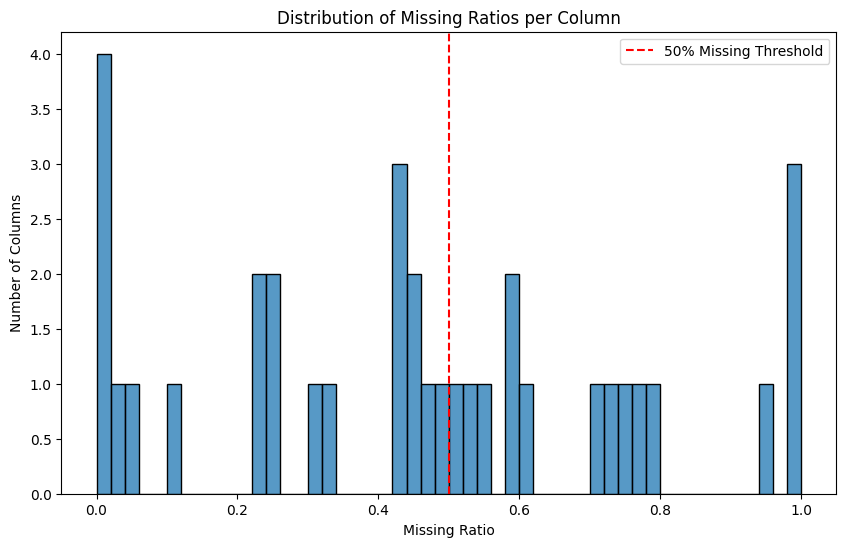

In [71]:
# First check the missing rate (proportion of NaN values).  
# If a column has a missing rate > 50%, drop it (don’t include it in later analysis).
missing_ratio = enzy_data.isnull().sum() / len(enzy_data)
print("Sorted missing ratio per column (top 10 with most missing values):")
print(missing_ratio.sort_values(ascending=False).head(10))
print("\n")
print(f"Total columns with 1+ missing values: {len(missing_ratio)}")
print(f"Max missing ratio: {missing_ratio.max()}")
print(f"Min missing ratio: {missing_ratio.min()}")
print("\n")
print(f"Columns with missing ratio >0%: {missing_ratio[missing_ratio > 0].count()}")
print(f"Columns with missing ratio >25%: {missing_ratio[missing_ratio > 0.25].count()}")
print(f"Columns with missing ratio >50%: {missing_ratio[missing_ratio > 0.5].count()}")
print(f"Columns with missing ratio >75%: {missing_ratio[missing_ratio > 0.75].count()}")
print("\n")

# plot missing ratio distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(missing_ratio, bins=50, kde=False)
plt.title("Distribution of Missing Ratios per Column")
plt.xlabel("Missing Ratio")
plt.ylabel("Number of Columns")
plt.axvline(0.5, color='red', linestyle='--', label='50% Missing Threshold')
plt.legend()
plt.show()


Base on the plot above, we decided to make the missing threshold to be 50%.

In [72]:
print(f"Original Dimension: {enzy_data.shape}")

# Remove columns with >50% missing values.
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()

print(f"Dropping {len(cols_to_drop)} columns with >50% missing values.")

# Drop these columns from the dataset.
enzy_data = enzy_data.drop(columns=cols_to_drop)

# Check the new dataset dimensions (rows, columns) after dropping.
print(f"Updated Dimension: {enzy_data.shape}")
print("\n")

# Check the missing rate again to confirm.
missing_ratio = enzy_data.isnull().sum() / len(enzy_data)
print(f"Max missing ratio: {missing_ratio.max()}")
print(f"Min missing ratio: {missing_ratio.min()}")

Original Dimension: (242115, 35)
Dropping 15 columns with >50% missing values.
Updated Dimension: (242115, 20)


Max missing ratio: 0.4909856886190447
Min missing ratio: 0.0


### 2.2 Understand Data Types ###

In [73]:
# Check the data types of each column.
print("Data types of each column:")
print(enzy_data.dtypes.value_counts())

Data types of each column:
object     17
float64     3
Name: count, dtype: int64


As shown in the output of the cell above, most columns are objects rather than numerical data. However, we can see that some numerical data are incorrectly categrized as object (e.g. `kcat = 1188 min^-1`). We will further process the dataset to eliminate such case. 

First of all, we need some shared parsing functions to convert strings to float decimals.

In [128]:
# --- core: convert one numeric token (e, x10^, messy spaces) to float ---
def _convert_token(token: str) -> float:
    if token is None:
        return np.nan
    t = str(token).strip()
    if t == "":
        return np.nan

    # normalize symbols/spaces
    t = t.replace(",", "")
    t = t.replace("×", "x").replace("X", "x")
    t = re.sub(r"\s+", "", t)  # collapse all spaces

    # 1) try plain float (also handles '1.2e3')
    try:
        return float(t)
    except ValueError:
        pass

    # 2) try a 'base x 10^exp' pattern (caret optional)
    m = re.match(r"^([\+\-]?\d*\.?\d+)\s*x\s*10\^?([\+\-]?\d+)$", t, re.IGNORECASE)
    if m:
        base = float(m.group(1))
        exp  = int(m.group(2))
        return base * (10 ** exp)

    # 3) as a last attempt, tolerate 'x10exp' with missing caret like '1.2x10-3'
    m2 = re.match(r"^([\+\-]?\d*\.?\d+)\s*x\s*10([\+\-]?\d+)$", t, re.IGNORECASE)
    if m2:
        base = float(m2.group(1))
        exp  = int(m2.group(2))
        return base * (10 ** exp)

    return np.nan

# --- high-level: parse single value or range and return a float (mean if range) ---
def parse_numeric_or_range(s: str):
    """
    Parse numeric or range strings:
      - '1.3e4', '1.3 × 10^4', '2x10^3'
      - '1.3e4 - 1.5e4'
      - '1.20 ± 0.09' → 1.20
    Ignores trailing units (e.g. 's^-1', 'per min').
    Returns midpoint for ranges or single value for ± notation.
    """
    if not s:
        return np.nan

    text = str(s).strip()
    if text == "":
        return np.nan

    # normalize
    t = text.replace("×", "x").replace("X", "x").replace("–", "-").replace("—", "-").replace("−", "-")
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"\bto\b", "-", t, flags=re.IGNORECASE)

    # Remove ± error parts (e.g. "1.20 ± 0.09" → "1.20")
    t = re.sub(r"\s*±\s*[\d\.eE\+\-]+", "", t)

    # Remove trailing unit strings
    t = re.sub(r"\s*(/|per|s|h|min|^-1|m|-1|µg|ug|%|fold|wt).*", "", t, flags=re.IGNORECASE).strip()

    # find up to two numeric tokens (range)
    token_pattern = r"([\+\-]?\d*\.?\d+(?:[eE][\+\-]?\d+)?|[\+\-]?\d*\.?\d+\s*[x×X]\s*10\^?[\+\-]?\d+)"
    tokens = re.findall(token_pattern, t)

    if not tokens:
        return np.nan

    if len(tokens) == 1:
        return _convert_token(tokens[0])

    # if two+ tokens, assume it's a range
    low = _convert_token(tokens[0])
    high = _convert_token(tokens[1])
    mean = (low + high) / 2.0 if np.isfinite(low) and np.isfinite(high) else np.nan
    return mean

# -----------------------
# Quick examples:
# print(parse_numeric_or_range("1.3e4 - 1.5e4"))               # 14000.0
# print(parse_numeric_or_range("2.0x10^3 to 2.3x10^3"))        # 2150.0
# print(parse_numeric_or_range("5.6 ×10 2 – 6.4 × 10^2"))      # 600.0
# print(parse_numeric_or_range("1.2e3", return_bounds=True))   # (1200.0, 1200.0, 1200.0)
# print(parse_numeric_or_range('1.5 to 8.2'))  # (7.65e-05, 7.2e-05, 8.1e-05)

def extract_numeric_segment(text):
    """
    Extract numeric portion (possibly with ± error or range) from a string that may include units.
    Returns:
      (numeric_part: str, had_unit: bool)

    Examples:
      "1.3e4 - 1.5e4 m^-1" -> ("1.3e4 - 1.5e4", True)
      "2.0x10^3/s"         -> ("2.0x10^3", True)
      "1.20 ± 0.09 s^-1"   -> ("1.20 ± 0.09", True)
      "1.20 ± 0.09"        -> ("1.20 ± 0.09", False)
    """
    if not text:
        return "", False

    t = str(text).strip()
    t = t.replace("×", "x").replace("X", "x")
    t = re.sub(r"\s+", " ", t)

    # Match numeric part: allow optional ± ... uncertainty OR range
    numeric_pattern = re.compile(
        r"""
        ^\s*
        (?P<num>
            [\d\.\+\-eExx^×\s]+              # main number or sci notation
            (?:\s*(?:±|[-–—to])\s*[\d\.\+\-eExx^×\s]+)?  # optional ± or range
        )
        (?P<unit>.*)$                        # rest of string = possible unit
        """,
        re.VERBOSE | re.IGNORECASE,
    )

    m = numeric_pattern.match(t)
    if not m:
        return t, False

    numeric_part = m.group("num").strip()
    unit_part = m.group("unit").strip()

    # Determine if there was unit text that isn't part of ± error
    # e.g. in "1.20 ± 0.09 s^-1", the "s^-1" part counts as a unit
    had_unit = bool(unit_part)

    return numeric_part, had_unit

# # ------------------------
# # Examples
# tests = [
#     "1.3e4 - 1.5e4 m^-1",
#     "2.0x10^3/s",
#     "5.6 ×10 2 per min",
#     "7.2e-5–8.1e-5 s^-1",
#     "  1.2e3 ",
# ]
# for s in tests:
#     print(f"{s!r} -> {extract_numeric_segment(s)!r}")

# print(extract_numeric_segment("1.4 - 2.8"))  # ("1.3e4 - 1.5e4", True)
# print(parse_numeric_or_range("1.4 - 2.8"))  # ("1.3e4 - 1.5e4", True)

### 2.1.1 Analyzing and Processing Kcat ###

           kcat  kcat_s^-1
0   1188 min^-1  19.800000
1   1636 min^-1  27.266667
2     39 min^-1   0.650000
3     89 min^-1   1.483333
4      2.5 s^-1   2.500000
5   0.0014 s^-1   0.001400
6      9.1 s^-1   9.100000
7      4.6 s^-1   4.600000
8  0.00035 s^-1   0.000350
9     17.4 s^-1  17.400000


count    2.268050e+05
mean     2.511244e+03
std      2.169576e+05
min     -1.400000e+07
25%      1.700000e-01
50%      2.900000e+00
75%      2.220000e+01
max      3.996000e+07
Name: kcat_s^-1, dtype: float64


Kcat Data Quality Summary:
invalid_value       : 1294
relative            : 4185
activity_based      : 1362
invalid_unit        : 8469
valid               : 220359


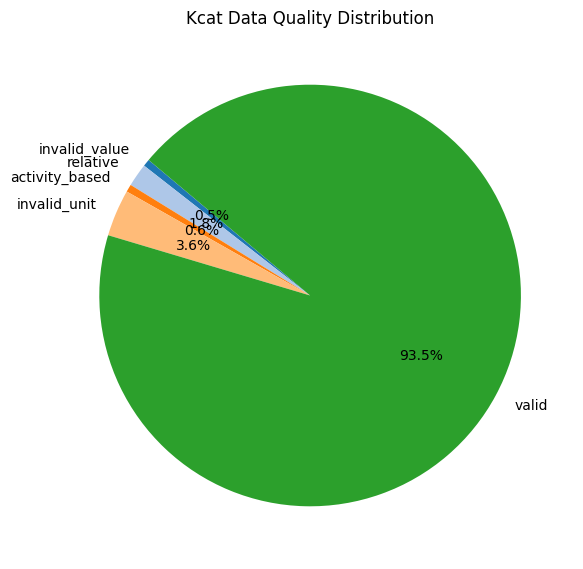

In [ ]:
# --- Initialize all counters ---
kcat_counts = {
    "invalid_value": 0, # failed to parse numeric value
    "relative": 0, # requires a baseline to interpret
    "activity_based": 0, # activity-based units like µg, U/min
    "invalid_unit": 0, # unrecognized or unsupported units like cm, m^-2
    "valid": 0,
}

# --- kcat cleaning function ---
def clean_kcat(value):
    if pd.isna(value):
        return np.nan

    text = str(value).strip().lower()

    # Skip invalid or relative entries
    if any(keyword in text for keyword in ["increase", "decrease", "vary", "unknown", "fold", "n/a", "not", "%"]):
        kcat_counts["relative"] += 1
        return np.nan

    # Skip invalid area/distance-based units
    if any(unit in text for unit in ["^-2", "squared", "m^-2", "cm^-2", "per m^-2", "per cm^-2", "cm", "m "]):
        kcat_counts["invalid_unit"] += 1
        return np.nan

    # Extract numeric segment and unit flag
    numeric_seg, had_unit = extract_numeric_segment(text)
    if not numeric_seg:
        kcat_counts["invalid_value"] += 1
        return np.nan

    base_value = parse_numeric_or_range(numeric_seg)
    if not np.isfinite(base_value):
        kcat_counts["invalid_value"] += 1
        return np.nan

    # --- Standardize to s^-1 ---
    if any(x in text for x in ["per day", "/day", "d^-1", "day^-1"]):
        kcat_counts["valid"] += 1
        return base_value / 86400.0
    elif any(x in text for x in ["per h", "/h", "h^-1", "hr^-1", "hour^-1"]):
        kcat_counts["valid"] += 1
        return base_value / 3600.0
    elif any(x in text for x in ["per min", "/min", "min^-1", "minute^-1"]):
        kcat_counts["valid"] += 1
        return base_value / 60.0
    elif any(x in text for x in ["per s", "/s", "s^-1", "second^-1"]):
        kcat_counts["valid"] += 1
        return base_value
    elif not had_unit: 
        return base_value # no unit specified, assuming it is already in s^-1
    elif any(x in text for x in ["µg", "ug", "u/"]):
        kcat_counts["activity_based"] += 1
        return np.nan
    else:
        kcat_counts["invalid_unit"] += 1
        # print(f"⚠️ Invalid unit: '{text}' → base={base_value}, seg='{numeric_seg}'") # Uncomment for debugging
        return np.nan


# --- Apply cleaning ---
enzy_data["kcat_s^-1"] = enzy_data["kcat"].apply(clean_kcat)

# --- Summary output ---
print(enzy_data[["kcat", "kcat_s^-1"]].head(10))
print("\n")
print(enzy_data["kcat_s^-1"].describe())
print("\n")

# --- Report counts ---
print("Kcat Data Quality Summary:")
for k, v in kcat_counts.items():
    print(f"{k:20s}: {v}")

# --- Pie chart visualization ---
plt.figure(figsize=(6, 6))
labels = list(kcat_counts.keys())
sizes = list(kcat_counts.values())
colors = plt.cm.tab20.colors[:len(labels)]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Kcat Data Quality Distribution")
plt.tight_layout()
plt.show()

// todo: check outliers

### 2.1.2 Analyzing and Processing Km ###

             km      Km_µM
0        2.7 µM      2.700
1        2.6 µM      2.600
2        1.7 µM      1.700
3        2.0 µM      2.000
4       1.09 µM      1.090
5      0.035 µM      0.035
6       0.40 µM      0.400
7      10016 µM  10016.000
8      0.012 µM      0.012
9  9.5 ± 1.7 µM      9.500

Km_M describe:
 count    1.857070e+05
mean     1.329573e+06
std      1.575774e+08
min     -7.000000e+05
25%      1.240000e+01
50%      1.350000e+02
75%      1.118500e+03
max      5.236850e+10
Name: Km_µM, dtype: float64

Km data quality counts:
valid          : 185707
relative       : 547
invalid_parse  : 677


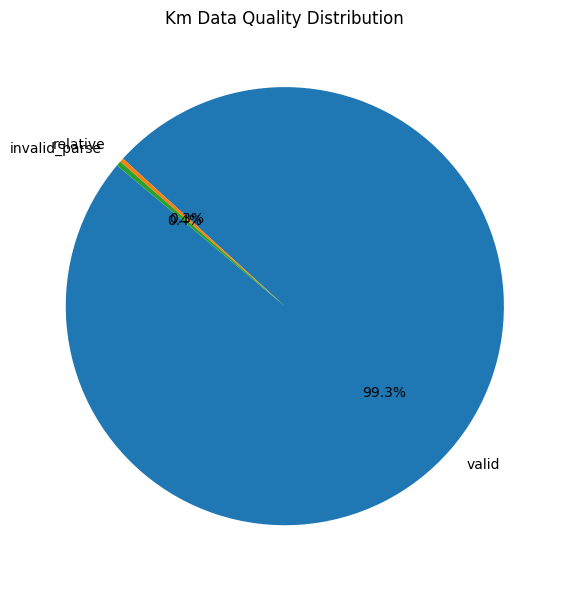

In [147]:

km_counts = {
    "valid": 0,            
    "relative": 0,         # %, fold/change wording, etc.
    "invalid_parse": 0,    # couldn't parse any numeric
}

# ---------------------------
# Unit helpers
# ---------------------------
_MICRO_CHARS = ("µ", "μ")  # possible micro symbols

def _normalize_mu(s: str) -> str:
    # unify μ/µ to 'µ' so we can check both µM and uM easily
    for ch in _MICRO_CHARS:
        s = s.replace(ch, "µ")
    return s

# Priority-ordered unit patterns → (unit_label, factor_to_M)
# We check the ORIGINAL (case-sensitive) text to avoid confusing µm (micrometer) vs µM (micromolar).
_KM_UNIT_PATTERNS = [
    (r"\bpM\b", 1e-12, "pM"),
    (r"\bnM\b", 1e-9,  "nM"),
    (r"\bµM\b|\buM\b|\bμM\b", 1e-6, "µM"),
    (r"\bmM\b", 1e-3,  "mM"),
    (r"\bM\b",  1.0,   "M"),
    # mol/L family (case-insensitive), with SI prefixes:
    (r"(?i)\bp?mol\s*/\s*l\b|\bp?mol\s*l\^?-1\b", 1e-12, "pMol/L"),
    (r"(?i)\bn?mol\s*/\s*l\b|\bn?mol\s*l\^?-1\b", 1e-9,  "nMol/L"),
    (r"(?i)\bµ?mol\s*/\s*l\b|\bu?mol\s*/\s*l\b|\bµ?mol\s*l\^?-1\b|\bu?mol\s*l\^?-1\b", 1e-6, "µMol/L"),
    (r"(?i)\bmmol\s*/\s*l\b|\bmmol\s*l\^?-1\b", 1e-3,    "mMol/L"),
    (r"(?i)\bmol\s*/\s*l\b|\bmol\s*l\^?-1\b",   1.0,     "Mol/L"),
]

def _detect_km_unit_and_factor(original_text: str):
    """Return (factor_to_M, matched_label) or (None, None) if no match."""
    # Try simple molarity labels first (case-sensitive for 'M'):
    for pat, factor, label in _KM_UNIT_PATTERNS:
        if re.search(pat, original_text):
            return factor, label
    return None, None

# ---------------------------
# Clean Km: produce standard unit = M (mol/L)
# ---------------------------
def clean_km(value, assume_unit: str = None):
    """
    Cleans a Km entry:
      - Parses number or range (midpoint) using parse_numeric_or_range()
      - Detects unit; converts to M (mol/L)
      - If no unit and assume_unit is provided in {'M','mM','µM','uM','nM','pM'}, it will convert accordingly
      - Else no-unit becomes NaN and counted in km_counts['no_unit']
    """
    if pd.isna(value):
        return np.nan

    original = str(value).strip()
    if original == "":
        return np.nan

    # quick screens for relative/invalid words
    lowered = _normalize_mu(original).lower()
    if any(tok in lowered for tok in ["%", "increase", "decrease", "fold", "vary", "unknown", "n/a", "not"]):
        km_counts["relative"] += 1
        return np.nan

    # Extract numeric portion (keep ± if present; parse_numeric_or_range will ignore ± and take the base)
    numeric_seg, had_unit = extract_numeric_segment(original)
    if not numeric_seg:
        km_counts["invalid_parse"] += 1
        # print(f"⚠️ Invalid parse: '{original}' → seg='{numeric_seg}'")  # Uncomment for debugging
        return np.nan

    val = parse_numeric_or_range(numeric_seg)
    if not np.isfinite(val):
        km_counts["invalid_parse"] += 1
        # print(f"⚠️ Invalid parse: '{original}' → seg='{numeric_seg}'")  # Uncomment for debugging
        return np.nan

    # Unit detection on original (case-sensitive to keep M vs m)
    factor, matched = _detect_km_unit_and_factor(original)

    if factor is None:
        # If no explicit unit found
        if assume_unit is None:
            km_counts["no_unit"] += 1
            return np.nan
        # apply assumed unit
        unit_map = {"M":1.0, "mM":1e-3, "µM":1e-6, "uM":1e-6, "nM":1e-9, "pM":1e-12}
        f = unit_map.get(assume_unit, None)
        if f is None:
            km_counts["invalid_unit_2"] += 1
            return np.nan
        km_counts["valid"] += 1
        return val * f

    # Convert to M
    km_counts["valid"] += 1
    return val * factor 


# ---------------------------
# Apply to your dataframe
# ---------------------------
# Choose whether to assume a default unit when none is provided.
# Commonly Km is reported in µM; if you want that behavior, pass assume_unit="µM" (or "uM").
# If you prefer to leave no-unit rows as NaN, keep assume_unit=None (default).
enzy_data["Km_µM"] = enzy_data["km"].apply(lambda x: clean_km(x, assume_unit="µM") /1e-6 )

# ---------------------------
# Inspect + summarize
# ---------------------------
print(enzy_data[["km", "Km_µM"]].head(10))
print("\nKm_M describe:\n", enzy_data["Km_µM"].describe())
print("\nKm data quality counts:")
for k, v in km_counts.items():
    print(f"{k:15s}: {v}")

# ---------------------------
# Pie chart of data quality
# ---------------------------
labels = list(km_counts.keys())
sizes = list(km_counts.values())
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Km Data Quality Distribution")
plt.tight_layout()
plt.show()

# # ---------------------------
# # Histogram of Km values (in µM)
# # ---------------------------

# # Filter valid Km values (in µM)
# km_values = enzy_data["Km_µM"].dropna()

# plt.figure(figsize=(8, 5))
# sns.histplot(km_values, bins=50, kde=True, color='steelblue')

# # Log scale because Km spans wide range
# plt.xscale('log')
# plt.xlabel("Km (µM, log scale)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Km Values (µM)")
# plt.grid(True, which="both", ls="--", alpha=0.5)
# plt.tight_layout()
# plt.show()

/Users/yang/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yang/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yang/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yang/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


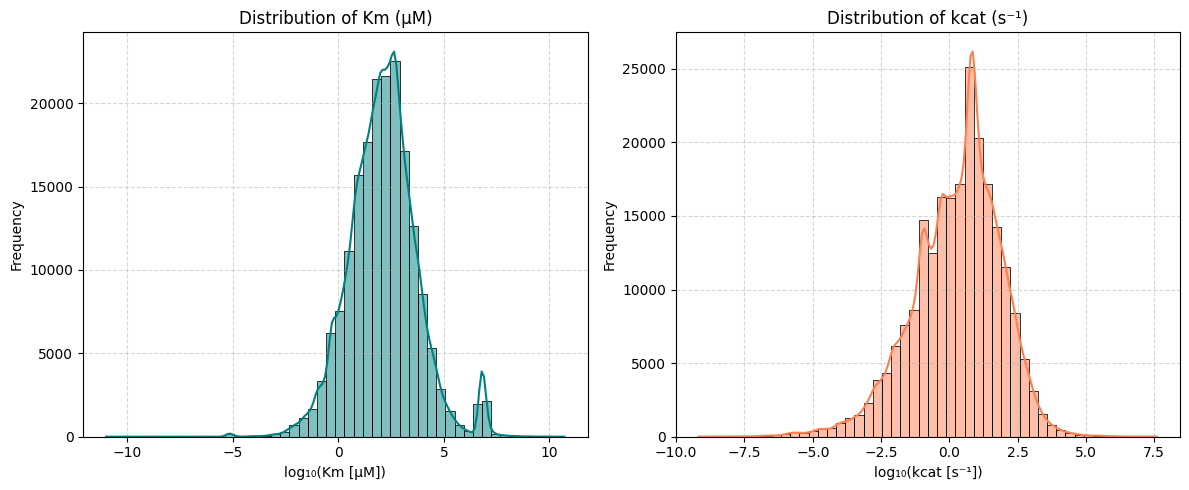

In [148]:
# Drop NaNs for both
km_values = enzy_data["Km_µM"].dropna()
kcat_values = enzy_data["kcat_s^-1"].dropna()

# ----- Plot side-by-side -----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Km (µM)
sns.histplot(np.log10(km_values), bins=50, kde=True, color="teal", ax=axes[0])
axes[0].set_xlabel("log₁₀(Km [µM])")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Km (µM)")
axes[0].grid(True, ls="--", alpha=0.5)

# kcat (s⁻¹)
sns.histplot(np.log10(kcat_values), bins=50, kde=True, color="coral", ax=axes[1])
axes[1].set_xlabel("log₁₀(kcat [s⁻¹])")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of kcat (s⁻¹)")
axes[1].grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# 删除 sequence 列中为空（NaN 或 None）的行
enzy_data_clean = enzy_data.dropna(subset=['sequence']).reset_index(drop=True)

# 检查结果
print(f"删除后剩余行数: {len(enzy_data_clean)}")

删除后剩余行数: 138141


In [ ]:
#temerature和pH值太复杂了，需要讨论一下是否需要保留还是直接去除

def _mid_of_range(a: float, b: float) -> float:
    """区间中点"""
    return (a + b) / 2.0

def parse_temperature_to_c(text):
    """解析各种温度表达为摄氏度(float)，无法解析则 NaN"""
    if pd.isna(text):
        return np.nan

    s = str(text).strip()
    s_norm = (s.lower()
                .replace("° c", "°c")
                .replace("deg c", "°c")
                .replace("℃", "°c")
                .replace(" ", " "))

    # 明确无温度
    if "not explicitly mentioned" in s_norm:
        return np.nan

    # Room/Ambient temperature直接设置为 22°C
    if "room temperature" in s_norm or "ambient temperature" in s_norm or "ambient temperatures" in s_norm:
        # 若有括号数字 → 解析
        m = re.search(r"\((.*?)\)", s_norm)
        if m:
            inner = m.group(1)
            m_range = re.search(r"([0-9.]+)\s*[–-]\s*([0-9.]+)", inner)
            if m_range:
                return _mid_of_range(float(m_range.group(1)), float(m_range.group(2)))
            m_num = re.search(r"([0-9.]+)", inner)
            if m_num:
                return float(m_num.group(1))
        # 没有数字 → 强制设为 22°C
        return 22.0

    # 逗号前温度（如 "25, pH 7"）
    before_comma = s_norm.split(",")[0].strip()

    # 区间 a–b °C / K
    m = re.search(r"([+-]?\d+(?:\.\d+)?)\s*[–-]\s*([+-]?\d+(?:\.\d+)?)\s*°?\s*([ck])", before_comma)
    if m:
        a, b, unit = float(m.group(1)), float(m.group(2)), m.group(3)
        val = _mid_of_range(a, b)
        if unit == "k":
            val -= 273.15
        return val

    # ± 形式
    m = re.search(r"([+-]?\d+(?:\.\d+)?)\s*±\s*[+-]?\d*(?:\.\d+)?\s*°?\s*([ck])", before_comma)
    if m:
        val, unit = float(m.group(1)), m.group(2)
        if unit == "k":
            val -= 273.15
        return val

    # 单值 °C
    m = re.search(r"([+-]?\d+(?:\.\d+)?)\s*°?\s*c\b", before_comma)
    if m:
        return float(m.group(1))

    #单值 K → °C
    m = re.search(r"([+-]?\d+(?:\.\d+)?)\s*k\b", before_comma)
    if m:
        return float(m.group(1)) - 273.15

    # approx / approximately / ~
    m = re.search(r"(?:approx(?:imately)?\.?|~)\s*([+-]?\d+(?:\.\d+)?)\s*°?\s*c", s_norm)
    if m:
        return float(m.group(1))

    #无单位纯数字（默认认为是摄氏度）
    m = re.search(r"^([+-]?\d+(?:\.\d+)?)$", before_comma)
    if m:
        return float(m.group(1))

    #裸数字 + pH 语义（例如 "25, pH 7"）
    m = re.search(r"([+-]?\d+(?:\.\d+)?)\b", before_comma)
    if m and ("ph" in s_norm or "approx" in s_norm):
        return float(m.group(1))

    return np.nan

#apply fucntion
enzy_data_clean["temperature_C"] = enzy_data_clean["temperature"].apply(parse_temperature_to_c)

# 生成新表，只保留成功解析的行
enzy_data_pro = enzy_data_clean[enzy_data_clean["temperature_C"].notna()].copy()

print(enzy_data_clean[["temperature", "temperature_C"]].head(15))
print("\n新表 enzy_data_pro 的维度：", enzy_data_pro.shape)

   temperature  temperature_C
0         None            NaN
1         None            NaN
2         None            NaN
3         None            NaN
4         None            NaN
5         None            NaN
6         None            NaN
7         None            NaN
8         None            NaN
9         37°C           37.0
10        25°C           25.0
11        25°C           25.0
12        25°C           25.0
13        25°C           25.0
14        25°C           25.0

新表 enzy_data_pro 的维度： (107264, 24)


In [ ]:
#对enzy_data_pro里面的sequence_source进行one-hot编码处理
from sklearn.preprocessing import OneHotEncoder
#处理blanks
enzy_data_pro['sequence_source'] = enzy_data_pro['sequence_source'].fillna('unknown')
# 初始化 One-Hot 编码器
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 拟合并转换
sequence_encoded = encoder.fit_transform(enzy_data_pro[['sequence_source']])

#  创建新的 One-Hot DataFrame
sequence_ohe_cols = [f"sequence_{cat}" for cat in encoder.categories_[0]]
sequence_ohe_df = pd.DataFrame(sequence_encoded, columns=sequence_ohe_cols, index=enzy_data_pro.index)

# 合并回原表
enzy_data_pro = pd.concat([enzy_data_pro, sequence_ohe_df], axis=1)

# 检查结果
print(enzy_data_pro.head())


               enzyme                   enzyme_full     substrate  \
9   guanine deaminase                          None       guanine   
10               Pb5R  NADH-cytochrome b5 reductase           Pb5   
11               Pb5R  NADH-cytochrome b5 reductase           Pb5   
12               Pb5R  NADH-cytochrome b5 reductase  Ferricyanide   
13               Pb5R  NADH-cytochrome b5 reductase  Ferricyanide   

            organism           kcat            km                 kcat_km  \
9              Human      17.4 s^-1  9.5 ± 1.7 µM  11.8 × 10^3 s^-1 mM^-1   
10  Escherichia coli  510 ± 50 s^-1  8.8 ± 1.8 µM                    None   
11  Escherichia coli  510 ± 50 s^-1  8.8 ± 1.8 µM                    None   
12  Escherichia coli  630 ± 60 s^-1  2.5 ± 0.5 µM                    None   
13  Escherichia coli  630 ± 60 s^-1  2.5 ± 0.5 µM                    None   

   temperature          pH                           descriptor  ... km_µM  \
9         37°C  6.5 to 7.5  recombinant huma

In [ ]:
#去除原始列
enzy_data_pro = enzy_data_pro.drop(columns=["kcat", "km", "kcat_km", "temperature","sequence_source"], errors='ignore')

In [ ]:
#kcat/km/kcat_km/temperature数值型分析,可以加上pH列
num_cols = ["kcat_s^-1", "km_μM","kcat_km_M^-1_s^-1", "temperature_C","kcat_value","km_value","max_enzyme_similarity"]

#用直方图（hist）+ KDE 查看分布；用箱型图（boxplot）检测极端值
for col in num_cols:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(enzy_data_pro[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.subplot(1,2,2)
    sns.boxplot(x=enzy_data_pro[col], color='lightcoral')
    plt.title(f"Boxplot of {col}")
    plt.show()


In [ ]:
#sequence_source查看频率
cat_counts = sequence_ohe_df.value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=cat_counts.values, y=cat_counts.index, color='lightgreen')
plt.title("Frequency of Sequence Source")
plt.xlabel("Count")
plt.ylabel("Source Type")
plt.show()

In [ ]:
#不同来源与指标的关系：不同 sequence_source 下的 kcat_s^-1 或 temperature_C 差异
plt.figure(figsize=(8,5))
sns.boxplot(data=enzy_data_pro, x='sequence_source_encoded', y='kcat_s^-1')
plt.xticks(rotation=45)
plt.title("kcat_s^-1 Distribution by Sequence Source")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=enzy_data_pro, x='sequence_source_encoded', y='temperature_C')
plt.xticks(rotation=45)
plt.title("temperature_C Distribution by Sequence Source")
plt.show()

In [ ]:
#特征间的关系与相关性：分析哪些物理化学指标之间存在潜在关系
corr = enzy_data_pro[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between numerical features")
plt.show()

In [ ]:
#PCA降维
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 预处理：数值(每个酶类别进行聚合后中位数填补+标准化)
import pandas as pd
import numpy as np

def stratified_fill_then_drop(
    df: pd.DataFrame,
    target_cols,
    group_tiers=None,
    strategy: str = "median",
    verbose: bool = True,
    inplace: bool = False,
) -> pd.DataFrame:

    if group_tiers is None:
        group_tiers = [
            ["enzyme_full", "substrate"],
            ["enzyme_full"],
            ["enzyme", "substrate"],
            ["enzyme"],
            ["substrate"],
        ]

    dfx = df if inplace else df.copy()

    # 仅保留存在且数值型的目标列
    target_cols = [c for c in target_cols
                   if c in dfx.columns and pd.api.types.is_numeric_dtype(dfx[c])]
    if verbose:
        print("Target numeric columns:", target_cols)

    agg_fn = np.nanmedian if strategy == "median" else np.nanmean

    # 逐层直接回填
    for tier_cols in group_tiers:
        tier_cols = [c for c in tier_cols if c in dfx.columns]
        if not tier_cols:
            continue
        if verbose:
            print(f"\nTier: {tier_cols}")

        g = dfx.groupby(tier_cols, dropna=False)

        for col in target_cols:
            # 组统计量与原索引对齐（transform）
            stats_aligned = g[col].transform(agg_fn)
            before = dfx[col].isna().sum()
            dfx[col] = dfx[col].fillna(stats_aligned)
            after = dfx[col].isna().sum()
            if verbose:
                print(f"  {col}: filled {before - after}")

    # 全部层级后：仍缺失的行直接删除
    na_before = dfx.shape[0]
    dfx = dfx.dropna(subset=target_cols)
    na_after = dfx.shape[0]
    if verbose:
        print(f"\nDropped rows with remaining NA in {target_cols}: {na_before - na_after}")

    return dfx


In [ ]:
#先得到预处理后的稠密矩阵，再用 PCA 看解释率并自动选维度
X_dense = pre.fit_transform(enzy_data_pro)
print("Dense feature shape:", X_dense.shape)

#看碎石图 & 累计方差
pca_full = PCA(random_state=42).fit(X_dense)
evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

plt.figure(figsize=(7,3.5))
plt.plot(range(1, len(evr)+1), evr, marker='o')
plt.title("PCA Explained Variance Ratio per PC (Dense)")
plt.xlabel("PC")
plt.ylabel("EVR")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.5))
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.axhline(0.95, color='r', ls='--', label='95%')
plt.title("PCA Cumulative Explained Variance (Dense)")
plt.xlabel("PC"); plt.ylabel("Cumulative EVR"); plt.legend()
plt.tight_layout(); plt.show()

#选取达到 95% 方差的最小维度
n95 = int(np.argmax(cum >= 0.95) + 1)
print("n_components for ≥95% variance:", n95)

pca = PCA(n_components=n95, random_state=42)
X_pca = pca.fit_transform(X_dense)

pc_cols = [f"PC{i+1}" for i in range(n95)]
enzy_data_pca_dense = pd.concat(
    [enzy_data_pro.reset_index(drop=True),
     pd.DataFrame(X_pca, columns=pc_cols)],
    axis=1
)

# 查看载荷（特征权重）：先拿到 one-hot 后的列名
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, cat_feature_names]

loadings = pd.DataFrame(pca.components_.T, index=feature_names, columns=pc_cols)
print("Top features on PC1:\n", loadings["PC1"].abs().sort_values(ascending=False).head(10))


In [ ]:
#绘制主成分散点图（PC1 vs PC2）
X_for_pca = enzy_data_pro.select_dtypes(include=['number'])
print("PCA 输入矩阵维度:", X_for_pca.shape)

#标准化数值特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_pca)

# PCA降维到2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 保存主成分结果到DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['sequence_source'] = enzy_data_pro['sequence_source']

#  绘制散点图
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='sequence_source',
    palette='Set2',
    s=60,
    alpha=0.8,
    edgecolor='k'
)
plt.title("PCA Scatter Plot (PC1 vs PC2)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)")
plt.legend(title='Sequence Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()